## Алгоритмы классификации: линейные методы, логистическая регрессия и SVM

### The Adult dataset
- Целевой переменной является уровень дохода **income**
- http://www.cs.toronto.edu/~delve/data/adult/adultDetail.html

In [17]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score

import warnings
warnings.simplefilter('ignore')

%matplotlib inline

#### Подключим файл с данными для анализа и посмотрим на содержимое

In [18]:
dataset = pd.read_csv("/Users/aleksandr/Desktop/Архив/adult.csv")

In [19]:
dataset.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [20]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
age                48842 non-null int64
workclass          48842 non-null object
fnlwgt             48842 non-null int64
education          48842 non-null object
educational-num    48842 non-null int64
marital-status     48842 non-null object
occupation         48842 non-null object
relationship       48842 non-null object
race               48842 non-null object
gender             48842 non-null object
capital-gain       48842 non-null int64
capital-loss       48842 non-null int64
hours-per-week     48842 non-null int64
native-country     48842 non-null object
income             48842 non-null object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


In [21]:
dataset.describe()

,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week
count,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,1.896641e+05,10.078089,1079.067626,87.502314,40.422382
std,13.710510,1.056040e+05,2.570973,7452.019058,403.004552,12.391444
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175505e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781445e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376420e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


In [22]:
dataset.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'educational-num',
       'marital-status', 'occupation', 'relationship', 'race', 'gender',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income'],
      dtype='object')

In [23]:
dataset.income.value_counts()

<=50K    37155
>50K     11687
Name: income, dtype: int64

#### Из первичного анализа:
- можна выделить две строки "occupation" и "workclass" они содержат пустые значения записанные ввиде типа данных string символом "?"
- target значение плохо сбалансированно и имеет 2 класса

#### Далее
- переопределим "?" как np.NaN
- посмотрим какую долю занимают пропуски и выберим стратегию работы с выбросами

In [24]:
dataset = dataset.fillna(np.nan)
dataset[dataset == '?'] = np.nan

,Total,Percent
occupation,2809,5.751198
workclass,2799,5.730724
native-country,857,1.754637


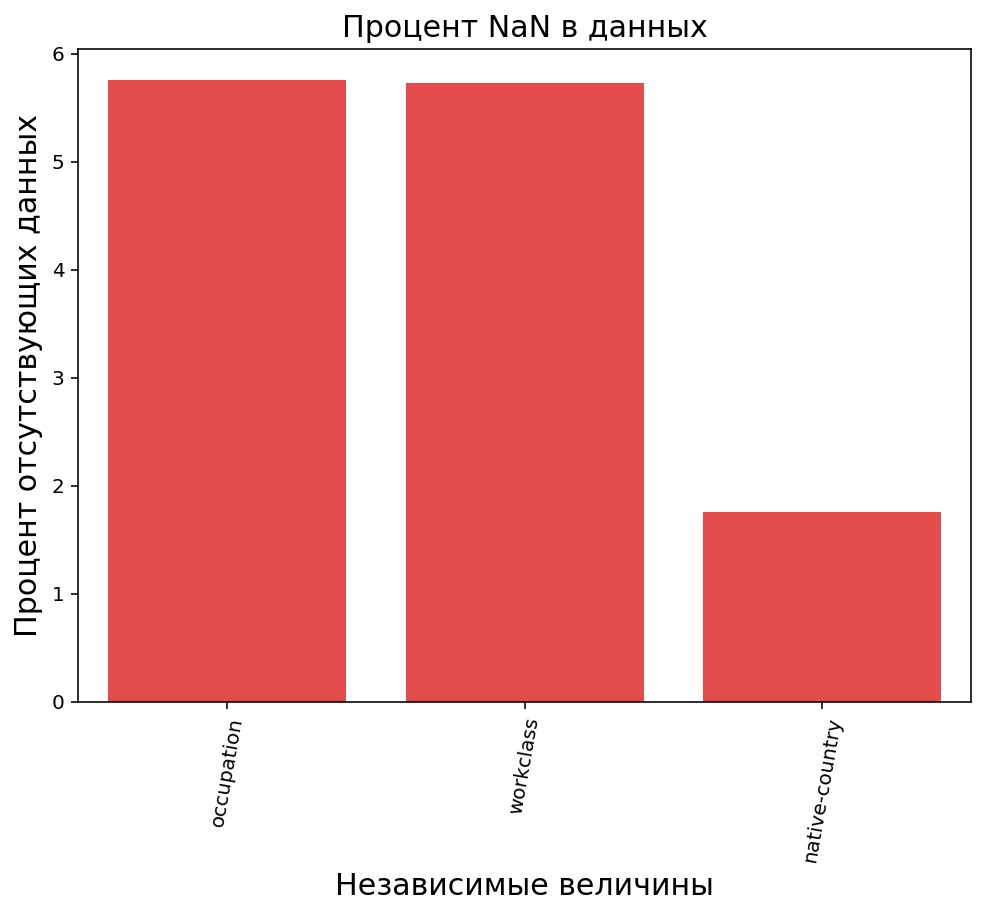

In [25]:
def missingdata(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    ms=pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    ms= ms[ms["Percent"] > 0]
    f,ax =plt.subplots(figsize=(8,6))
    plt.xticks(rotation='80')
    fig=sns.barplot(ms.index, ms["Percent"],color="red",alpha=0.8)
    plt.xlabel('Независимые величины', fontsize=15)
    plt.ylabel('Процент отсутствующих данных', fontsize=15)
    plt.title('Процент NaN в данных', fontsize=15)
    return ms

%config InlineBackend.figure_format = 'retina'
missingdata(dataset)

- очистим наш df переопределив его в другую переменную, но уже без пустых значений
- посмотрим остались ли выбросы в данных

In [26]:
data = dataset.dropna()

In [27]:
data.isnull().sum()

age                0
workclass          0
fnlwgt             0
education          0
educational-num    0
marital-status     0
occupation         0
relationship       0
race               0
gender             0
capital-gain       0
capital-loss       0
hours-per-week     0
native-country     0
income             0
dtype: int64

#### Теперь можно начать работу с категориальными данными и построением модели
1. Разделим наш df на **X** и **y**, где:
  - **y** содержит только **target**
  - **X** содержит остальные значения
2. Выберем из стратегий **get_dummies** и **LabelEncode** для работы с категориями: 
  - была выбрана **LabelEncoder** дабы не перенаполнять наш df
3. Нормализовать данные
4. Разбить на train и test (*0.2)
5. **По условиям задачи обучаем модель логистической регрессии**
6. Смотрим score 

In [28]:
X = data.drop(['income'], axis=1)
y = data['income']

In [29]:
X.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States
5,34,Private,198693,10th,6,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States


In [30]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 42)

In [31]:
categorical = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country']

for i in categorical:
        le = preprocessing.LabelEncoder()
        X_train[i] = le.fit_transform(X_train[i])
        X_test[i] = le.transform(X_test[i])

In [32]:
scaler = StandardScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns = X.columns)

In [33]:
X_train.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country
0,-0.726026,0.830625,0.700898,-0.350650,1.129197,0.943726,1.249306,-0.258636,0.385188,0.694522,-0.147342,-0.219322,-0.078584,0.262951
1,0.032168,-0.212689,-0.855543,-0.350650,1.129197,-0.388379,0.752462,2.246494,0.385188,-1.439840,-0.147342,-0.219322,0.754922,-4.338155
2,0.183807,-0.212689,0.451759,-0.350650,1.129197,-0.388379,0.752462,2.246494,0.385188,-1.439840,-0.147342,-0.219322,-2.162346,-5.324106
3,-1.332582,-0.212689,-0.761608,1.225150,-0.052582,0.943726,-0.241225,0.993929,0.385188,0.694522,-0.147342,-0.219322,-2.162346,0.262951
4,1.472738,-0.212689,0.159233,0.174617,-0.446509,-0.388379,-0.986491,-0.884918,0.385188,0.694522,-0.147342,-0.219322,0.754922,0.262951


In [34]:
logreg = LogisticRegression()

logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

print('Logistic Regression accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Logistic Regression accuracy score: 0.8211


In [35]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       <=50K       0.84      0.94      0.89      6842
        >50K       0.71      0.45      0.55      2203

    accuracy                           0.82      9045
   macro avg       0.78      0.69      0.72      9045
weighted avg       0.81      0.82      0.81      9045



### Дополнительно: 
- построю модель "метод опорных векторов" и сравню score с логистической регрессией

In [37]:
svc = svm.SVC(kernel='linear')

svc.fit(X_train, y_train)
y_pred=svc.predict(X_test)

print('SVM score: {0:0.4f}'. format(svc.score(X_test,y_test)))

SVM score: 0.8111


### Выводы:
- LogisticRegression ("логистическая регрессия") дала достаточно хороший результат 
 - Численная оценка качества алгоритма (accuracy_score) = 82.1%
- Стоит помнить, что плохо сбалансированные данные при использовании моделей регрессии, могут давать завышенные результаты оценки точности
- SVM ("метод опорных векторов") - 81.1%

##### Баланс таргета в dataset:
- "<=50K" = 37155
- ">50K" = 11687

##### Не в рамках данной работы: 
- можно уровнять sample и попробывать переобучиться
- попробывать другую стратегию работы с категориальными признаками

In [ ]:
pass